# Import thư viện cần thiét

In [20]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.cluster import KMeans


# Xây dựng mô hình EM phân loại người dùng

In [21]:
class CreditRiskEM:
    def __init__(self, n_clusters=3, max_iter=200, random_state=42, tol=1e-5):
        """
        Khởi tạo mô hình phân tích rủi ro tín dụng
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol
        np.random.seed(random_state)
    
    def preprocess_data(self, X):
        """
        Chuẩn hóa dữ liệu
        """
        scaler = StandardScaler()
        return scaler.fit_transform(X)
    
    def initialize_parameters(self, X):
        """
        Khởi tạo các tham số ban đầu cho thuật toán EM
        """
        n_samples, n_features = X.shape
        
        # Khởi tạo trọng số đồng đều
        self.weights = np.ones(self.n_clusters) / self.n_clusters
        
        # Chọn ngẫu nhiên các điểm làm trung tâm
        indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.means = X[indices]
        
        # Khởi tạo ma trận hiệp phương sai
        self.covariances = [self._robust_cov(X) for _ in range(self.n_clusters)]
    
    def _robust_cov(self, X, reg_coef=1e-6):
        """
        Tạo ma trận hiệp phương sai 
        """
        cov = np.cov(X.T)
        # Thêm hệ số chính quy hóa để đảm bảo ma trận khả nghịch
        return cov + reg_coef * np.eye(cov.shape[0])
    
    def e_step(self, X):
        """
        Bước Expectation: Tính xác suất thuộc nhóm
        """
        responsibilities = np.zeros((X.shape[0], self.n_clusters))
        
        for k in range(self.n_clusters):
            try:
                # Tính mật độ xác suất cho từng nhóm
                responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(
                    X, mean=self.means[k], cov=self.covariances[k], allow_singular=True
                )
            except Exception as e:
                print(f"Error in cluster {k}: {e}")
                # Fallback: sử dụng phân phối đều nếu có lỗi
                responsibilities[:, k] = self.weights[k] / X.shape[0]
        
        # Tránh chia cho 0
        row_sums = responsibilities.sum(axis=1)
        row_sums[row_sums == 0] = 1
        
        # Chuẩn hóa xác suất
        responsibilities /= row_sums[:, np.newaxis]
        return responsibilities
    
    def m_step(self, X, responsibilities):
        """
        Bước Maximization: Ước lượng lại các tham số
        """
        n_samples = X.shape[0]
        
        # Cập nhật trọng số
        N_k = responsibilities.sum(axis=0)
        self.weights = N_k / n_samples
        
        # Cập nhật trung bình
        self.means = np.dot(responsibilities.T, X) / N_k[:, np.newaxis]
        
        # Cập nhật ma trận hiệp phương sai
        for k in range(self.n_clusters):
            diff = X - self.means[k]
            weighted_diff = responsibilities[:, k][:, np.newaxis] * diff
            cov = np.dot(weighted_diff.T, diff) / N_k[k]
            
            # Thêm chính quy hóa để đảm bảo tính khả nghịch
            self.covariances[k] = cov + 1e-6 * np.eye(cov.shape[0])
    
    def fit(self, X):
        """
        Huấn luyện mô hình EM với điều kiện dừng dựa trên log-likelihood
        """
        # Tiền xử lý dữ liệu
        X_processed = self.preprocess_data(X)

        # Khởi tạo tham số
        self.initialize_parameters(X_processed)

        prev_log_likelihood = 0.0  # Giá trị log-likelihood ban đầu

        for i in range(self.max_iter):
            # Bước Expectation
            responsibilities = self.e_step(X_processed)

            # Tính log-likelihood hiện tại
            log_likelihood = self.compute_log_likelihood(X_processed, responsibilities)

            # Kiểm tra điều kiện hội tụ
            if prev_log_likelihood is not None:
                if abs(log_likelihood - prev_log_likelihood) < self.tol:
                    break

            # Cập nhật log-likelihood trước đó
            prev_log_likelihood = log_likelihood

            # Bước Maximization
            self.m_step(X_processed, responsibilities)

        # Gán nhóm cho từng điểm dữ liệu
        self.labels = responsibilities.argmax(axis=1)

        return self

    def compute_log_likelihood(self, X, responsibilities):
        """
        Tính giá trị log-likelihood tổng hợp
        """
        log_likelihood = 0.0

        for k in range(self.n_clusters):
            try:
                log_likelihood += np.sum(
                    responsibilities[:, k] * (
                        np.log(self.weights[k]) + 
                        multivariate_normal.logpdf(X, mean=self.means[k], cov=self.covariances[k], allow_singular=True)
                    )
                )
            except Exception as e:
                print(f"Error in computing log-likelihood for cluster {k}: {e}")

        return log_likelihood

    def predict_risk(self, X):
        """
        Dự đoán rủi ro cho tập huấn luyện
        """
        X_processed = self.preprocess_data(X)
        responsibilities = self.e_step(X_processed)
        
        # Tính xác suất rủi ro
        risk_probabilities = responsibilities.max(axis=1)
        predicted_clusters = responsibilities.argmax(axis=1)
        
        return predicted_clusters, risk_probabilities

# Các hàm visualize

In [22]:
def drawGraph(X, labels, means, covariances, n_clusters, z=None):
    """
    Vẽ biểu đồ phân nhóm và vòng tròn xung quanh các điểm thuộc từng cụm.
    Nếu z được cung cấp, chỉ vẽ z dòng đầu tiên của dữ liệu.
    """
    plt.figure(figsize=(8, 6))
    
    # Chuyển đổi dữ liệu thành numpy array nếu là pandas DataFrame
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    # Nếu z được cung cấp, chỉ vẽ z phần tử đầu tiên của dữ liệu
    if z is not None:
        X = X[:z]
        labels = labels[:z]

    # Chọn các màu khác nhau cho các cụm
    colors = plt.cm.get_cmap('tab10', n_clusters)  # Sử dụng bảng màu 'tab10' với n_clusters màu khác nhau
    
    # Vẽ các điểm dữ liệu của từng nhóm
    for cluster in range(n_clusters):
        cluster_data = X[labels == cluster]  # Lọc dữ liệu theo nhãn
        plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f"Cluster {cluster}", color=colors(cluster))

        # Vẽ vòng tròn bao quanh các điểm thuộc cụm
        mean = means[cluster]
        covariance = covariances[cluster]
        
        # Tính toán bán kính của vòng tròn từ ma trận hiệp phương sai
        eigenvalues, _ = np.linalg.eigh(covariance)
        radius = np.sqrt(np.max(eigenvalues))  # Sử dụng trị lớn nhất của eigenvalue làm bán kính
        
        # Vẽ vòng tròn bao quanh cụm
        circle = plt.Circle(mean, radius, color=colors(cluster), fill=False, linestyle='--')
        plt.gca().add_patch(circle)

    # Vẽ các trung tâm của các nhóm, tô màu theo màu của cluster
    for cluster in range(n_clusters):
        plt.scatter(means[cluster][0], means[cluster][1], marker='x', s=200, color=colors(cluster))  # Tô màu trung tâm
    
    plt.title("Clustering Results")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()


def load_and_prepare_data(file_path):
    """
    Tải và chuẩn bị dữ liệu
    """
    # Đọc dữ liệu
    df = pd.read_csv(file_path)
    
    # Chọn các đặc trưng
    features = [
        'RevolvingUtilizationOfUnsecuredLines', 
        'DebtRatio', 
        'MonthlyIncome', 
        'NumberOfTimes90DaysLate', 
        'age'
    ]
    
    # Mục tiêu dự báo
    target = 'SeriousDlqin2yrs'
    
    # Tách dữ liệu
    X = df[features]
    y = df[target]
    
    return X, y


def calculate_default_rate(y_true, predicted_clusters, n_clusters):
    """
    Tính tỷ lệ vỡ nợ trong mỗi nhóm rủi ro
    """
    default_rates = {}
    
    for cluster in range(n_clusters):
        # Lọc các bản ghi trong cluster hiện tại
        cluster_indices = np.where(predicted_clusters == cluster)[0]
        cluster_y = y_true.iloc[cluster_indices]
        
        # Tính tỷ lệ vỡ nợ trong nhóm
        default_rate = cluster_y.mean()
        default_rates[cluster] = default_rate
    
    return default_rates


def print_default_rates(y_true, predicted_clusters, n_clusters):
    """
    In tỷ lệ vỡ nợ cho từng nhóm rủi ro trong tập huấn luyện.
    """
    # Tính tỷ lệ vỡ nợ
    default_rates = calculate_default_rate(y_true, predicted_clusters, n_clusters)

    # Đảm bảo tất cả các nhóm từ 0 đến n_clusters-1 đều có mặt trong kết quả
    for cluster in range(n_clusters):
        rate = default_rates.get(cluster, 0)  # Nếu không có dữ liệu cho nhóm, mặc định tỷ lệ là 0
        print(f"Tỷ lệ vỡ nợ trong nhóm {cluster}: {rate:.4f}")
    
    print("\n---\n")

# Main

Tỷ lệ vỡ nợ trong nhóm 0: 0.0647
Tỷ lệ vỡ nợ trong nhóm 1: 0.0149
Tỷ lệ vỡ nợ trong nhóm 2: 0.3081

---

Dữ liệu đã được lưu vào file 'data_EM.csv'.


C:\Users\MSI VN\AppData\Local\Temp\ipykernel_14732\303226027.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)  # Sử dụng bảng màu 'tab10' với n_clusters màu khác nhau


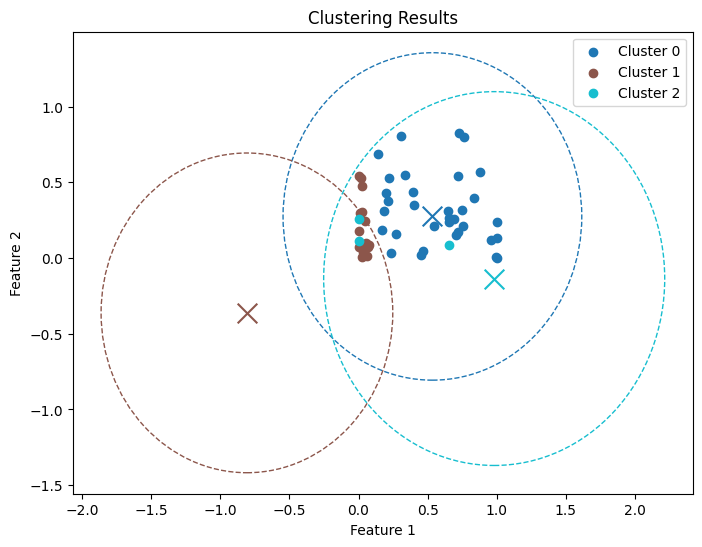

In [23]:
# Đường dẫn tới file dữ liệu
file_path = 'data_preprocessed.csv'

# Số lượng cụm
n_clusters = 3  

# Tải dữ liệu
X, y = load_and_prepare_data(file_path)

# Áp dụng thuật toán EM
em_model = CreditRiskEM(n_clusters=n_clusters)
em_model.fit(X)

# In tỷ lệ vỡ nợ cho từng nhóm trong tập huấn luyện
print_default_rates(y, em_model.labels, n_clusters=n_clusters)

# Tạo file dữ liệu mới với cột nhóm phân loại
df = pd.read_csv(file_path)
df['Cluster'] = em_model.labels

# Lưu dữ liệu vào file CSV mới
df.to_csv('data_EM.csv', index=False)
print("Dữ liệu đã được lưu vào file 'data_EM.csv'.")

drawGraph(X, em_model.labels, em_model.means, em_model.covariances, n_clusters=n_clusters, z=50)


Ứng dụng thực tế:

Kết quả phân cụm này có thể được sử dụng để xây dựng chính sách tín dụng:

Nhóm 1: Cấp tín dụng dễ dàng hơn với lãi suất ưu đãi.

Nhóm 0: Tăng cường theo dõi khả năng thanh toán, có thể áp dụng lãi suất trung bình.

Nhóm 2: Hạn chế cấp tín dụng hoặc yêu cầu bảo đảm tài sản.


In [29]:


# Đường dẫn tới file dữ liệu
file_path = 'data_preprocessed.csv'

# Số lượng cụm
n_clusters = 3  

# Tải dữ liệu
X, y = load_and_prepare_data(file_path)

# Tiền xử lý dữ liệu (chuẩn hóa)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Áp dụng thuật toán KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)

# In tỷ lệ vỡ nợ cho từng nhóm trong tập huấn luyện
print_default_rates(y, kmeans.labels_, n_clusters=n_clusters)

# Tạo file dữ liệu mới với cột nhóm phân loại
df = pd.read_csv(file_path)
df['Cluster'] = kmeans.labels_


Tỷ lệ vỡ nợ trong nhóm 0: 0.0696
Tỷ lệ vỡ nợ trong nhóm 1: 0.0178
Tỷ lệ vỡ nợ trong nhóm 2: 0.3081

---

Dữ liệu đã được lưu vào file 'data_KMeans.csv'.


Cả hai thuật toán đều nhận diện tốt nhóm khách hàng có rủi ro cao (Nhóm 2), với tỷ lệ vỡ nợ giống nhau là 30.81%. Tuy nhiên, EM tỏ ra nhỉn hơn đôi chút trong việc phân cụm các nhóm khách hàng có rủi ro thấp, khi tỷ lệ vỡ nợ của Nhóm 0 và Nhóm 1 lần lượt là 6.47% và 1.49%, thấp hơn so với KMeans (6.96% và 1.78%). Điều này cho thấy EM phù hợp hơn trong việc xử lý các dữ liệu phức tạp và mô hình hóa phân phối của các cụm, từ đó tăng độ chính xác trong phân tích tín dụng. Mặc dù KMeans là một thuật toán nhanh, dễ triển khai và cho kết quả tương đối tốt, EM lại cung cấp khả năng phân tích chi tiết hơn, đặc biệt quan trọng trong bối cảnh cần tối ưu hóa việc quản lý rủi ro tín dụng. Vì vậy, nếu ưu tiên độ chính xác, EM sẽ là lựa chọn phù hợp hơn trong bài toán này.